In [1]:
from pykeen.triples import TriplesFactory
from pykeen.models import predict
import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot as plt

In [2]:
def select_graph(n):
    th_lowEffect = 27.19266055 # means 399
    th_effective = 72.80733945 # means 149

    if n == 1:
        file_name = 'config_g1.csv'
    elif n == 2:
        file_name = 'config_g2.csv'
    else:
        file_name = 'config_g3.csv'
    return file_name, n, th_lowEffect, th_effective


# # Load Train data
def load_dataset(path, name):
    triple_data = open(path + name).read().strip()
    data = np.array([triple.split('\t') for triple in triple_data.split('\n')])
    tf_data = TriplesFactory.from_labeled_triples(triples=data)
    return tf_data, triple_data


# # Predict links (Head prediction)
def predict_heads(model, prop, obj, tf_testing):
    predicted_heads_df = predict.get_head_prediction_df(model, prop, obj, triples_factory=tf_testing)
    return predicted_heads_df


def get_config(config_file):
    config = pd.read_csv(config_file, delimiter=";") 
    models = config.model.values[0].split(',')
    epochs = config.epochs.values[0]
    k = config.k_fold.values[0]
    path = config.path.values[0]
    graph_name = config.graph_name.values[0]
    return models, epochs, k, path, graph_name


def get_threshold(predicted_heads, percentile):
    score_values = predicted_heads.score.values
    threshold = np.percentile(score_values, percentile)
    threshold_index = predicted_heads.loc[predicted_heads.score > threshold].shape[0]
    return threshold, threshold_index

def plot_score_value(score_values, response, th, min_s, max_s, n):
    x1, y1 = [th, th], [min_s, max_s]
    fig, ax = plt.subplots()
    plt.plot(score_values, label='score')
    plt.plot(x1, y1, label='cut-off', color='green')
    plt.xlabel("Entities")
    plt.ylabel("Score")
    plt.grid(False)
    ax.legend(loc='upper center', fontsize=16)

    if n == 1:
        plt.title('Score values of treatment response ' + response +' in ' + '${\cal{T\_KG}}_{basic}$',
                  loc='left', fontsize=16)
    elif n == 2:
        plt.title('Score values of treatment response ' + response +' in ' + '$\cal{T\_KG}$',
                  loc='left', fontsize=16)
    else:
        plt.title('Score values of treatment response ' + response +' in ' + '${\cal{T\_KG}}_{random}$',
                  loc='left', fontsize=16)
    #plt.savefig(fname='Plots/KG'+str(n)+'_Score_' + response + '_TransH.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()

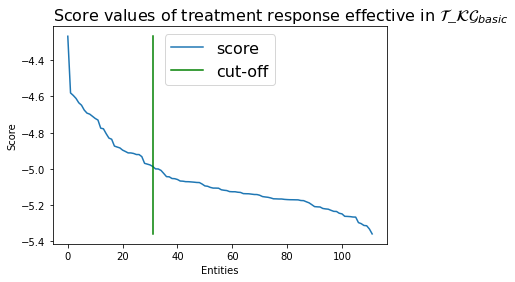

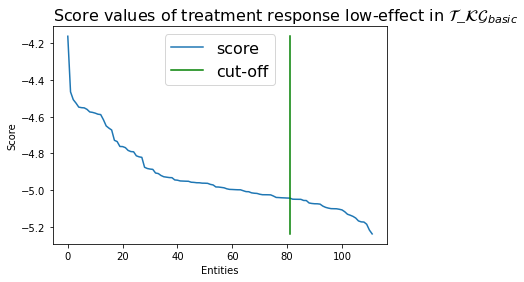

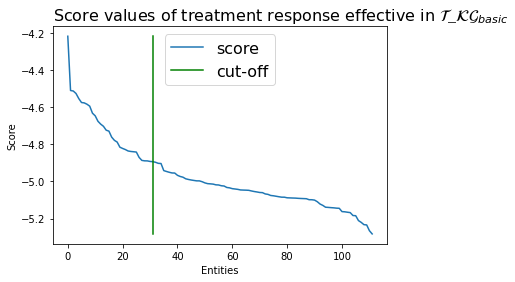

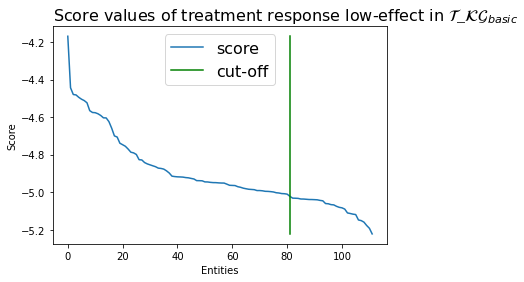

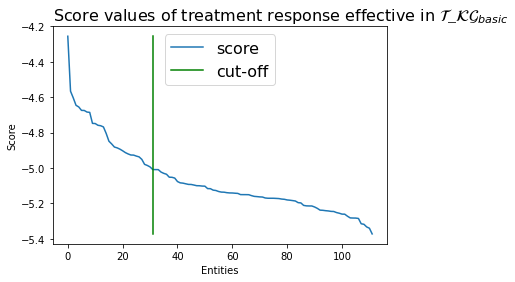

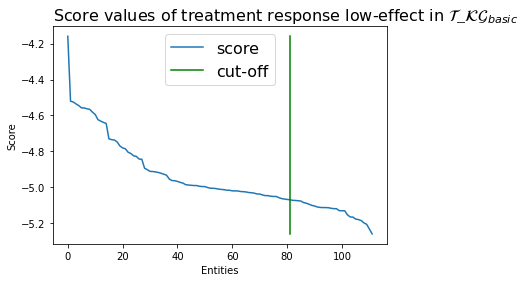

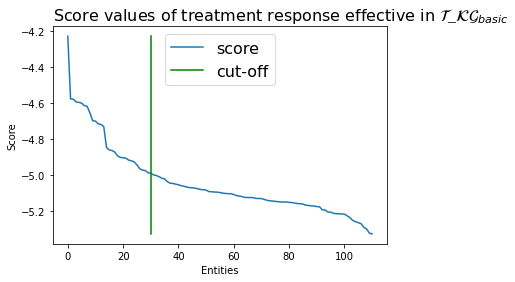

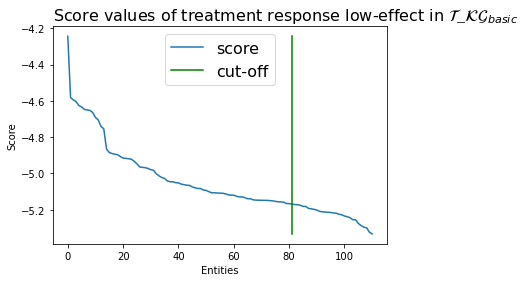

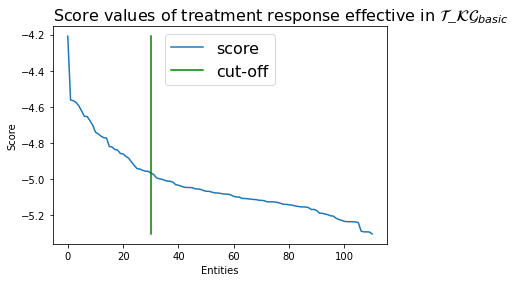

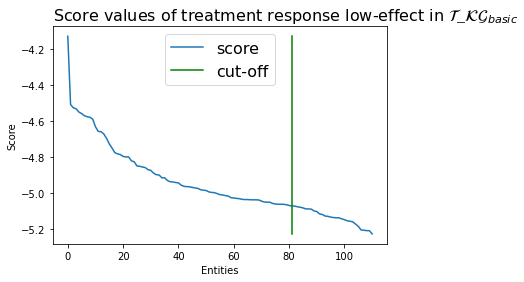

In [3]:
path = 'SubsymbolicSystem/Uniform/'
file_name, n, th_dec_eff, th_eff = select_graph(1)
models, epochs, k, graph, graph_name = get_config(path + file_name)

for m in models:
    for i in range(0, k):
        tf_training, triple_train = load_dataset(path + graph, 'train_' + str(i + 1) + '.ttl')
        tf_testing, triple_test = load_dataset(path + graph, 'test_' + str(i + 1) + '.ttl')
        model = torch.load(path + graph + m + str(i + 1) + '/trained_model.pkl', map_location='cpu')
        predicted_heads_eff = predict_heads(model, 'ex:belong_to', 'ex:effective', tf_testing) #tf_training
        predicted_heads_dec_eff = predict_heads(model, 'ex:belong_to', 'ex:low_effect', tf_testing)    
    
        
        score_values = predicted_heads_eff.score.values
        threshold, threshold_index = get_threshold(predicted_heads_eff, th_eff)
        plot_score_value(score_values, 'effective', threshold_index,
                         min(score_values), max(score_values), n)
        
        score_values = predicted_heads_dec_eff.score.values
        threshold, threshold_index = get_threshold(predicted_heads_dec_eff, th_dec_eff)
        plot_score_value(score_values, 'low-effect', threshold_index,
                         min(score_values), max(score_values), n)
#         break